# Attention and Transformers

This notebook demonstrates how to use self-attention to process a set of objects. This is the basic building block of a transformer (note: the original transformer paper introduces two parts, encoder and decoder, and uses both self-attention and attention; but other transformer implementations may use only the self-attention=encoding part as we are doing it here; BERT is an example).

2022 F.Marquardt and the MPL theory division machine learning discussion group;
MIT License

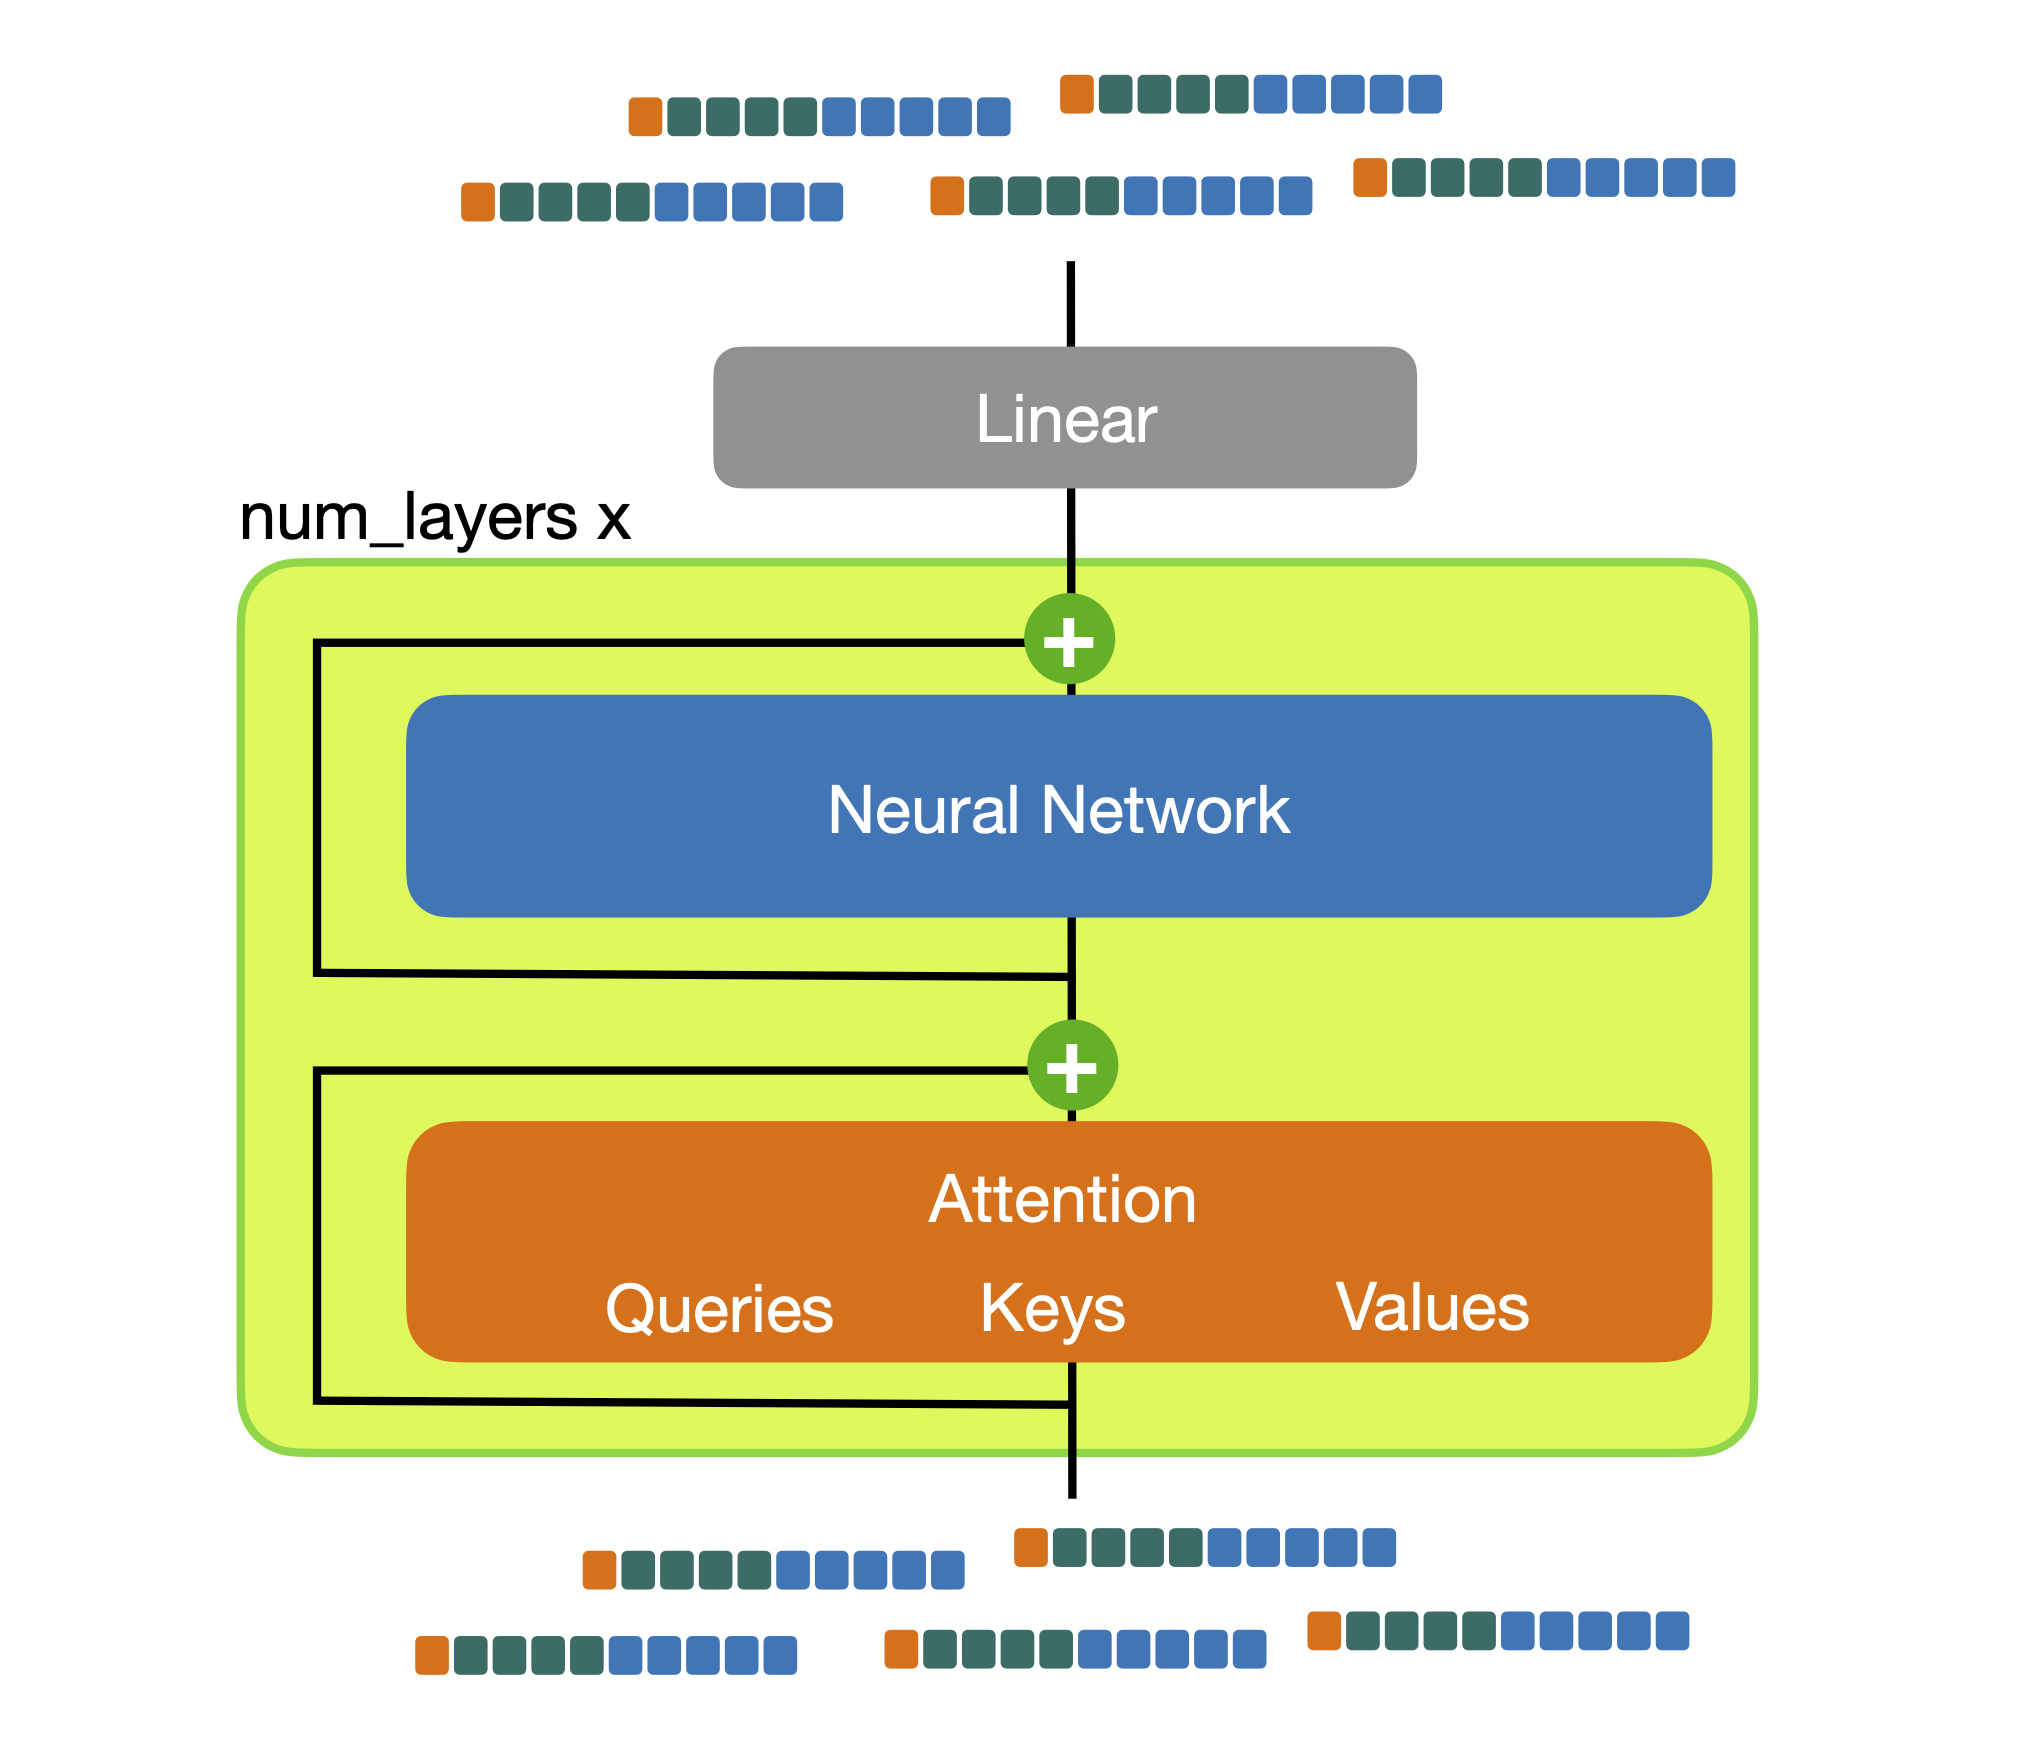

In [114]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'beige'


### All components of the Transformer

In [350]:
class TransformerBlock:
    def __init__(self,dim_data,dim_key,hidden_neurons_NN):
        """
        Produce a transformer block.
        
        dim_data:
            dimensionality of data vector (one such vector per object)
        dim_key:
            dim. of key vectors (extracted from data)
        hidden_neurons_NN:
            number of hidden neurons in the fully connected network
            
        Apply the resulting transformer block instance like you would apply
        a function, to a tensor that represents data (set of objects).
        """
        self.WQ=tf.Variable(np.random.randn(dim_data,dim_key),dtype='float32')
        self.WK=tf.Variable(np.random.randn(dim_data,dim_key),dtype='float32')
        self.WV=tf.Variable(np.random.randn(dim_data,dim_data),dtype='float32')
        self.NN=tfk.Sequential([tfk.layers.Input(shape=(dim_data,)),tfk.layers.Dense(hidden_neurons_NN,activation='relu'),
                        tfk.layers.Dense(dim_data)])
        self.layer_normalization=[]
        for k in range(2):
            self.layer_normalization.append(tfk.layers.LayerNormalization())
        self.trainable_variables=([self.WQ,self.WK,self.WV]+self.NN.trainable_variables+
                                  self.layer_normalization[0].trainable_variables+
                                  self.layer_normalization[1].trainable_variables)

    def attention(self,queries,keys,values):
        """
        General (multi-head) attention operation.

        Take dot products between queries and keys to produce
        scores, and then return the values weighted according to the
        exponentials of those scores (i.e. using softmax).

        This is written such that it can be used both with and without
        multiple 'attention heads'.

        An arbitrary number num_queries of queries can be made to
        an arbitrary number num_objects of objects. In many applications,
        and especially for self-attention, these numbers are the
        same and represent the 'sequence length' (e.g. max. number of words
        in a sentence, possibly padded), where each object in the
        sequence generates a query, which is then compared against the
        keys of all objects.

        dim_key must be the same for the key and query vectors.

        queries.shape = [batchsize,(num_heads),num_queries,dim_key]
        keys.shape = [batchsize,(num_heads),num_objects,dim_key]
        values.shape = [batchsize,(num_heads),num_objects, dim_value]

        Returns weights (of shape [batchsize,(num_heads),num_queries,num_objects])
        and return_values (of shape [batchsize,(num_heads),num_queries, dim_value])
        """
        sqrt_dk=tf.sqrt( tf.cast( tf.shape(keys)[-1], dtype='float32' ) )
        # take dot product between queries and keys along dim_key dimension,
        # leaving behind shape [batchsize,(num_heads),num_queries,num_objects]
        dot_product = tf.reduce_sum( queries[...,None,:] * keys[...,None,:,:] , axis=-1 )
        # get weights via softmax applied to the scaled dot product
        weights = tf.nn.softmax(  dot_product / sqrt_dk ) # [batchsize,num_queries,num_objects]
        # return weights and weighted values
        return weights, tf.reduce_sum( weights[...,None] * values[...,None,:,:], axis=-2 )


    def __call__(self,data,store_attention_weights=None):
        """
        Apply the 'transformer block' to data. 
        (This works by just calling the TransformerBlock instance on data like a function)
        
        data.shape=[batchsize,num_objects,dim_data]
        
        This first applies attention,
        after extracting queries, keys, and values, using the matrices WQ,WK,WV,
        and afterwards it also applies the neural network NN. 
        Note that both the attention part and
        the NN part are applied with the "Add+Norm" operation, i.e. with a
        residual-type connection and a Layer Normalization. As explained
        in the original Transformer paper.

        store_attention_weights: if not None, points to a list, to which the
            current attention weights will be appended (used for visualization)
            
        Returns the processed set of objects, i.e. a new 'data' Tensor.
        """
        Q=data @ self.WQ # @ == matrix multiplication (acting on last index of left operand)
        K=data @ self.WK
        V=data @ self.WV
        intermediate = self.layer_normalization[0](data+self.attention(Q,K,V)[1])
        if store_attention_weights is not None:
            store_attention_weights.append(attention(Q,K,V)[0]) # call again (bit inefficient)
        return self.layer_normalization[1](intermediate+self.NN(intermediate))

# intermediate.shape = [batchsize,num_objects,dim_data]

class Transformer:
    def __init__(self,num_layers,dim_data,dim_key,hidden_neurons_NN):
        """
        Initialize a Transformer, consisting of num_layers TransformerBlock instances,
        each of them initialized according to dim_data,dim_key, and hidden_neurons_NN.
        """
        self.layers=[TransformerBlock(dim_data,dim_key,hidden_neurons_NN) for _ in range(num_layers)]
        self.W_final=tf.Variable(np.eye(dim_data)+0.01*np.random.randn(dim_data,dim_data),dtype='float32')
        self.b_final=tf.Variable(0.01*np.random.randn(dim_data),dtype='float32')
        self.trainable_variables=([self.W_final,self.b_final]+
                                  sum([ly.trainable_variables for ly in self.layers],[]))
    
    def __call__(self,data,store_attention_weights=None,
                     store_data_layers=None):
        """
        Apply several transformer layers to data and return new data.

        data.shape=[batchsize,num_objects,dim_data]

        WQ,WK,WV,NN are lists containing the weight matrices and networks for
        all the layers.

        layer_norms is a list of layer normalization layers (of length len(NN)*2)

        W_final and b_final are a matrix and vector for the last, linear layer,
        applied to the final output.

        store_attention_weights: if not None, points to a list, to which the attention
            weights are appended, for each layer
        store_data_layers: if not None, points to a list, to which data (including input)
            will be appended for each layer
        """
        if store_data_layers is not None:
            store_data_layers.append(data)
        for block in self.layers:
            data=block(data,store_attention_weights=store_attention_weights) # apply transformer block
            if store_data_layers is not None:
                store_data_layers.append(data)
        data = data @ self.W_final + self.b_final # final linear operation
        if store_data_layers is not None:
            store_data_layers.append(data)
        return data

### Toy example for attention

In [351]:
# very first simple toy test: (only attention)

# batchsize = 1, two queries with dim_key = 2
queries=tf.constant( [ [ [0.0, 1.0] , [1.0,0.0] ] ] )
# batchsize = 1, three keys with dim_key = 2
keys   =tf.constant( [ [ [1.0,0.5], [0.0, 0.8] , [-1.0,0.0]  ] ] )
# batchsize = 1, three values with dim_value = 4
values =tf.constant( [ [ [1.0,0,0,0], [0,2,0,0], [0,0.0,3,0] ]])

# initialize a TransformerBlock (but we will only use its attention method)
test_block=TransformerBlock(dim_data=4,dim_key=2,hidden_neurons_NN=10)

weights, return_values = test_block.attention(queries,keys,values)

for query_idx in range(2):
    print(f"Query #{query_idx}: {queries[0,query_idx,:]}")
    for object_idx in range(3):
        print(f"Key {keys[0,object_idx,:]} \
-> Weight: {100*weights[0,query_idx,object_idx]:.1f}%  / Value {values[0,object_idx,:]}")
    print(f"Return Value {np.round(return_values[0,query_idx,:],2)}")

Query #0: [0. 1.]
Key [1.  0.5] -> Weight: 34.0%  / Value [1. 0. 0. 0.]
Key [0.  0.8] -> Weight: 42.1%  / Value [0. 2. 0. 0.]
Key [-1.  0.] -> Weight: 23.9%  / Value [0. 0. 3. 0.]
Return Value [0.34 0.84 0.72 0.  ]
Query #1: [1. 0.]
Key [1.  0.5] -> Weight: 57.6%  / Value [1. 0. 0. 0.]
Key [0.  0.8] -> Weight: 28.4%  / Value [0. 2. 0. 0.]
Key [-1.  0.] -> Weight: 14.0%  / Value [0. 0. 3. 0.]
Return Value [0.58 0.57 0.42 0.  ]


## Particular Example: Database lookup

We have a set of objects that carry both a label and an attribute. In some objects the attribute is missing, which is indicated by some flag being 0 (otherwise, it is 1). The goal of our transformer will be, for each 'placeholder' object (where the attribute information is missing) to look up an object with the same label among all objects, and copy the attribute from there.

This demonstrates how transformers can operate on some unordered set of objects and exploit the attention mechanism to look up relevant information.

Labels and attributes will be provided as one-hot vectors, composing the full data vector for any object like shown in the example below. In a placeholder object, the attribute is just a zero vector.

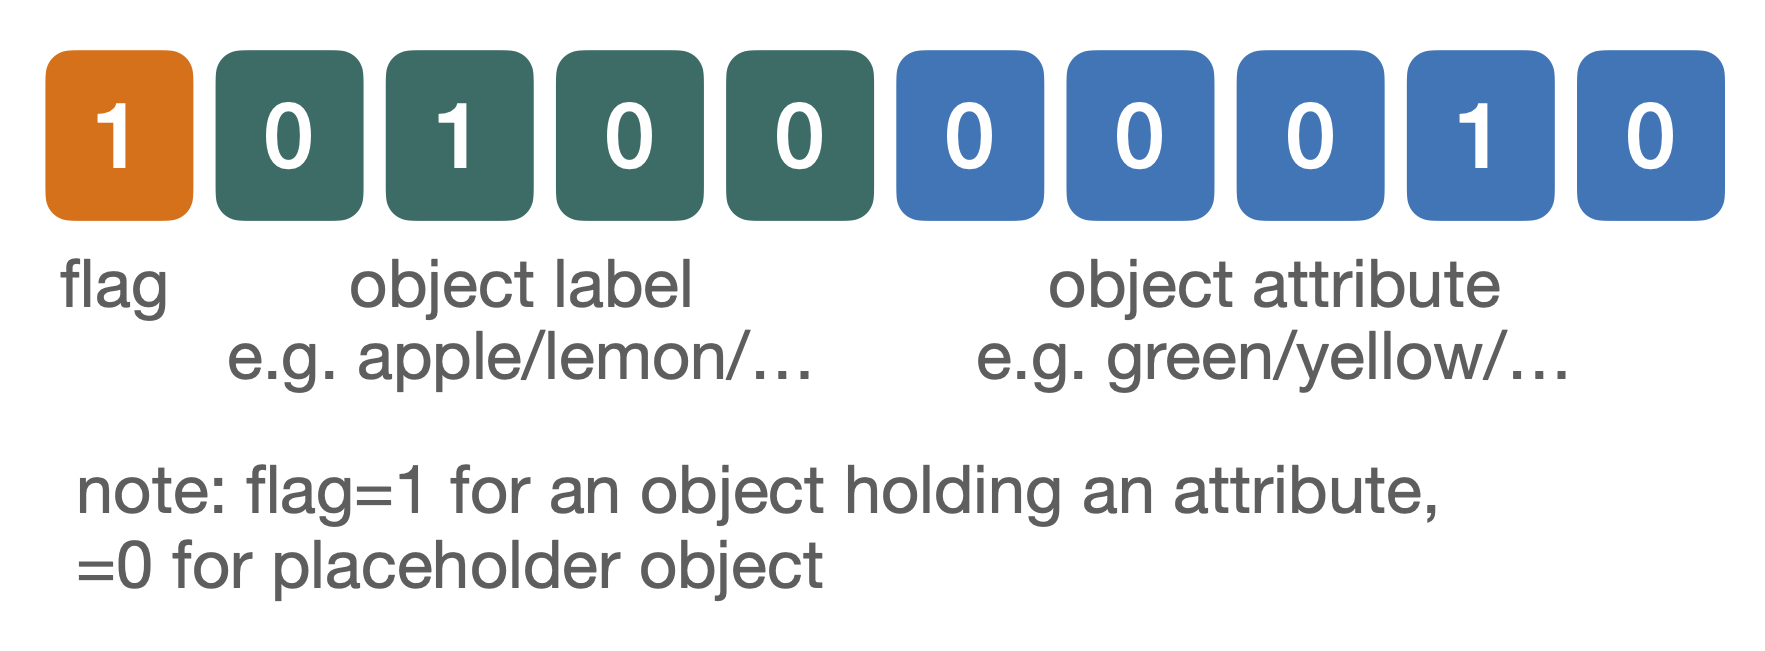

In [352]:
# Generate training sample for a database lookup scenario

# Example: The following set of objects...
# (0,  0,0,1,0,0,     0,0,0,0,0,0   )
# (1,  0,0,0,1,0,     0,0,1,0,0,0   )
# (1,  0,0,1,0,0,     0,0,0,0,1,0   )
# (0,  0,0,0,1,0,     0,0,0,0,0,0   )
# will be turned into: (* marks the changes)
# (0,  0,0,1,0,0,     0,0,0,0,*1*,0   )
# (1,  0,0,0,1,0,     0,0,1,0,0,0   )
# (1,  0,0,1,0,0,     0,0,0,0,1,0   )
# (0,  0,0,0,1,0,     0,0,*1*,0,0,0   )


def generate_batch_lookup_example(batchsize,num_objects, vector_length,
                                 provide_permutation=None):
    """
    Produce batch of sets of objects for the lookup
    training example: randomly sorted collections of objects of
    type (0,j,0) or (1,j,v_j) where v_j is a random one-hot vector, and
    there is always exactly one of each, for every j.
    The 'label' j is also treated as a one-hot vector in this version.
    
    So:
    
    (1,   0,1,0,   0,0,1,0,0)
    (0,   0,1,0,   0,0,0,0,0)
    
    should be turned into:
    
    (1,   0,1,0,   0,0,1,0,0)
    (0,   0,1,0,   0,0,**1**,0,0)
    
    where we marked the change with **
    
    Returns: input_batch,target_batch
    """
    assert num_objects%2==0, "need even number of objects."
    
    def single_sample():
        sample=np.zeros([num_objects,(1+num_objects//2+vector_length)])
        sample[:num_objects//2,0]=1
        for i in range(num_objects//2):
            sample[i,1+i] = 1
            sample[i+num_objects//2, 1+i] = 1
            random_int = np.random.randint(low=0, high=vector_length)
            sample[i, 1+num_objects//2+random_int] = 1
        
        target_sample=np.copy(sample)
        target_sample[num_objects//2:,1:]=sample[:num_objects//2,1:]
        return sample,target_sample
    
    
    input_batch=[]
    output_batch=[]
    
    # for each sample in the batchsize:
    # generate sample (a set of objects), and inside that sample randomly shuffle
    # the objects (in principle this is not needed, since the
    # transformer by construction is insensitive to the order
    # of objects, unless we add position encoding; but it is
    # nice to demonstrate that).
    for _ in range(batchsize):
        sample,target_sample=single_sample()
        permutation=np.random.permutation(num_objects)
        if provide_permutation is not None:
            provide_permutation.append(permutation)
        input_batch.append(sample[permutation,:])
        output_batch.append(target_sample[permutation,:])
        
    return np.array(input_batch),np.array(output_batch)


In [353]:
def train_step(input_batch, output_batch):
    """
    Apply the transformer to the input_batch, calculate mean-square-error
    against desired output_batch, and apply gradient descent on all trainable
    parameters (i.e. the W matrices in all transformer layers and the
    NN weights in all layers).
    """
    with tf.GradientTape() as tape:
        tape.watch(transformer.trainable_variables)
        data=input_batch
        data=transformer(data)
        loss=tf.reduce_sum((data-output_batch)**2)
    grads=tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(grads,transformer.trainable_variables))
    return loss


### Prepare Transformer

In [408]:
# Now prepare Transformer:

vector_length = 5 # length of the random one-hot vectors that represent the data stored
num_objects=8 # here: will keep it simple and act on a fixed number of objects

dim_data=1+num_objects//2 + vector_length # length of data vectors

dim_key=num_objects//2 # length of key vectors

num_layers=2 # how many Transformer layers (blocks) to apply

transformer=Transformer(num_layers=num_layers,dim_data=dim_data,dim_key=dim_key,hidden_neurons_NN=30)

### Training

In [409]:
# need to train for at least around 5000 steps for good performance in this example.
num_training_steps=5000
batchsize=10

# a learning rate schedule (ramping up and then down again, like in original Transformer paper)
# note: learning also works without this, but if this is chosen carefully, it speeds up
# convergence
class WarmUpSchedule(tfk.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_learning_rate, num_steps_until_maximum):
        self.max_learning_rate=max_learning_rate
        self.num_steps_until_maximum=num_steps_until_maximum

    def __call__(self, step):
        s=step/self.num_steps_until_maximum
        if s<1:
            return self.max_learning_rate*s
        else:
            return self.max_learning_rate*(s**(-0.5))

optimizer = tfk.optimizers.Adam(learning_rate=WarmUpSchedule(max_learning_rate=1e-2,
                                                             num_steps_until_maximum=1000))

losses=[] # comment out this line if continuing training!

for n_step in range(num_training_steps):
    input_batch,output_batch=generate_batch_lookup_example(batchsize,num_objects, vector_length)
    tf_input_batch = tf.convert_to_tensor(input_batch, tfk.backend.floatx())
    tf_output_batch = tf.convert_to_tensor(output_batch, tfk.backend.floatx())
    loss = train_step(tf_input_batch, tf_output_batch)
    print(f"Step {n_step} Loss {loss.numpy()}",end="     \r")
    losses.append(loss.numpy())

2022-01-15 21:12:15.296920: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-01-15 21:12:15.297290: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-01-15 21:12:15.297679: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2022-01-15 21:12

2022-01-15 21:12:15.498372: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 978).
2022-01-15 21:12:15.498961: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 978).
2022-01-15 21:12:15.499160: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 978).
2022-01-15 21:12

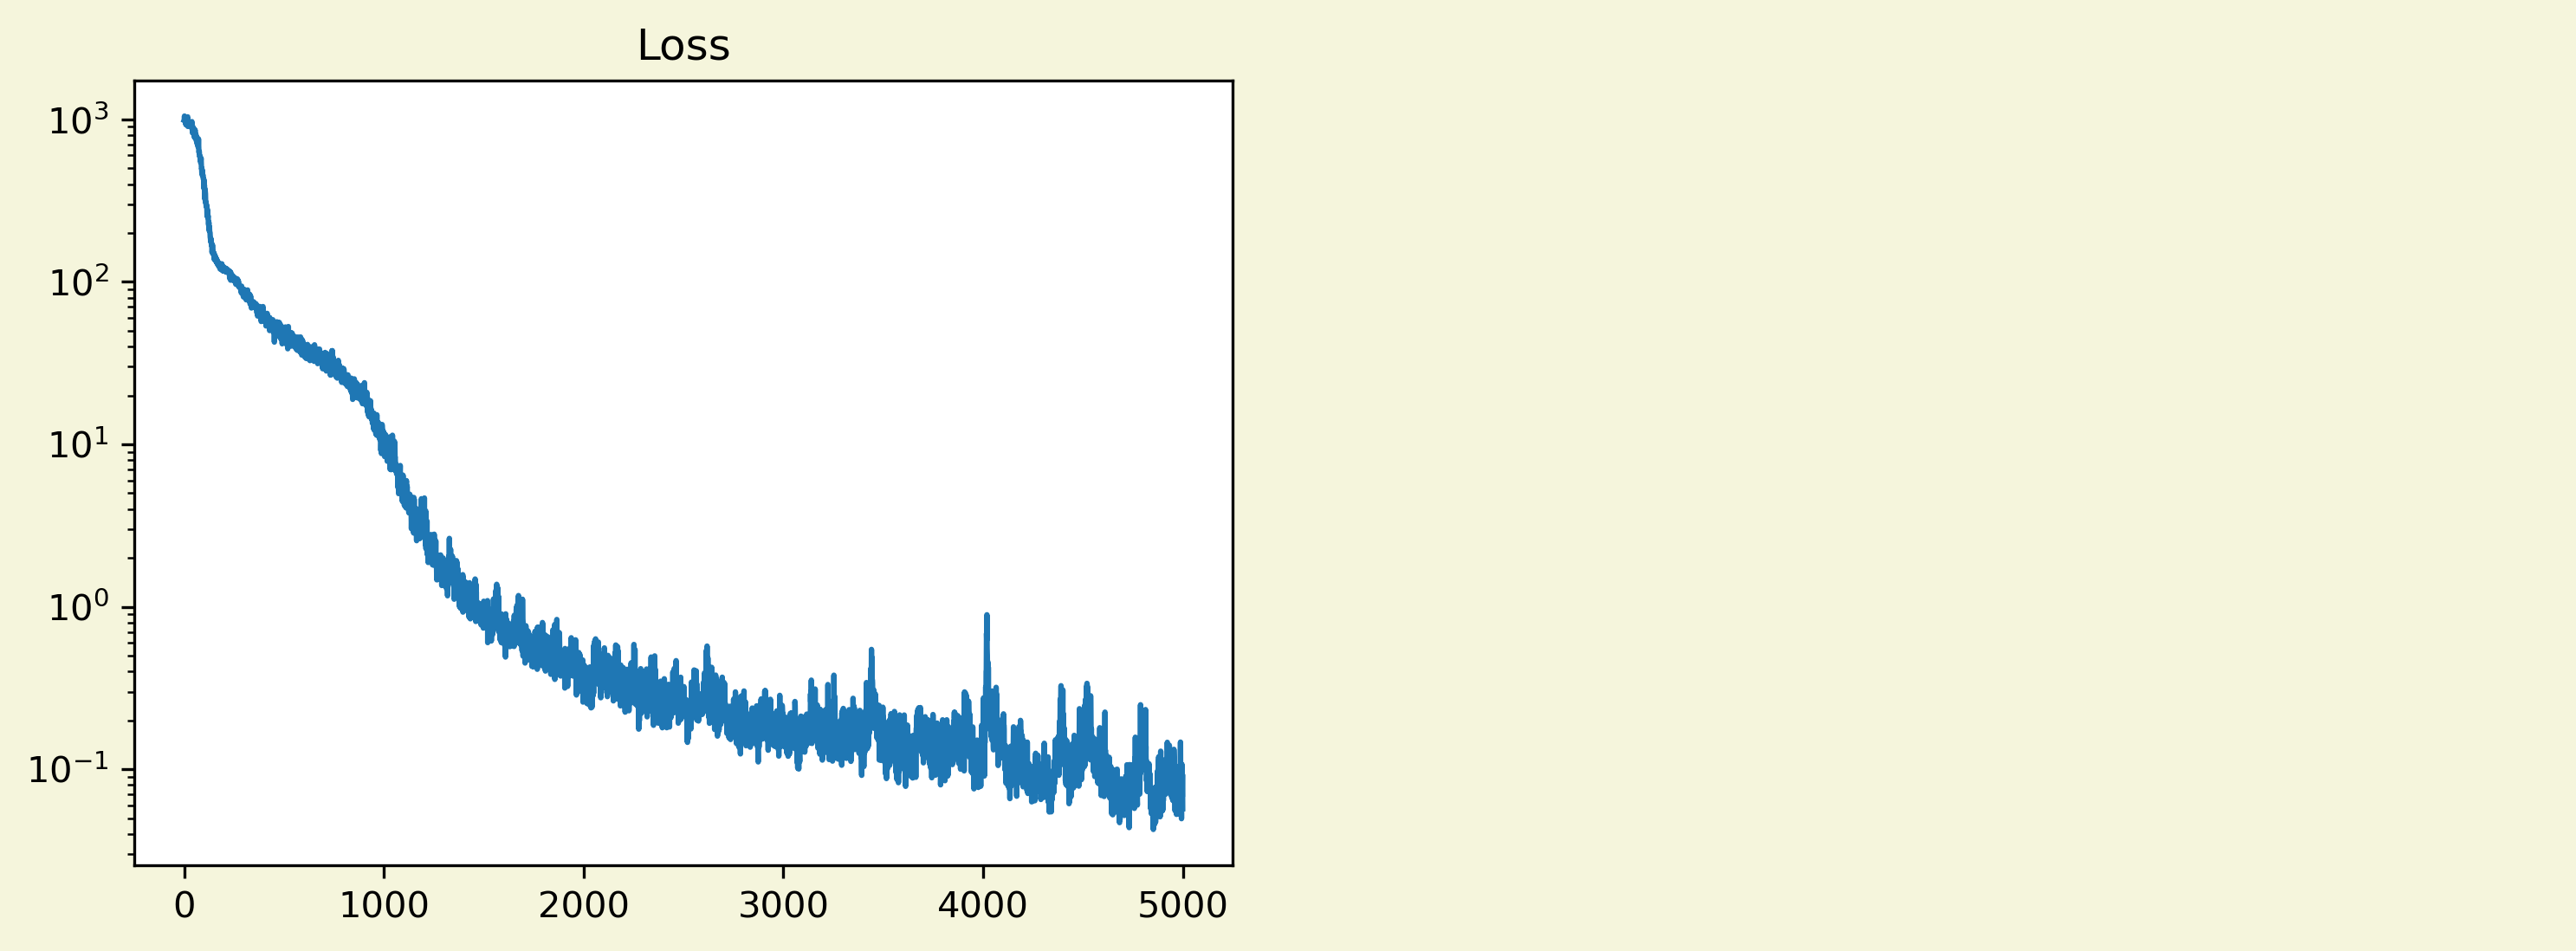

In [410]:
fig,ax=plt.subplots(ncols=2,dpi=300,figsize=(12,4))
ax[0].semilogy(losses)
ax[0].set_title("Loss")
ax[1].axis('off')
plt.show()

### Analysis

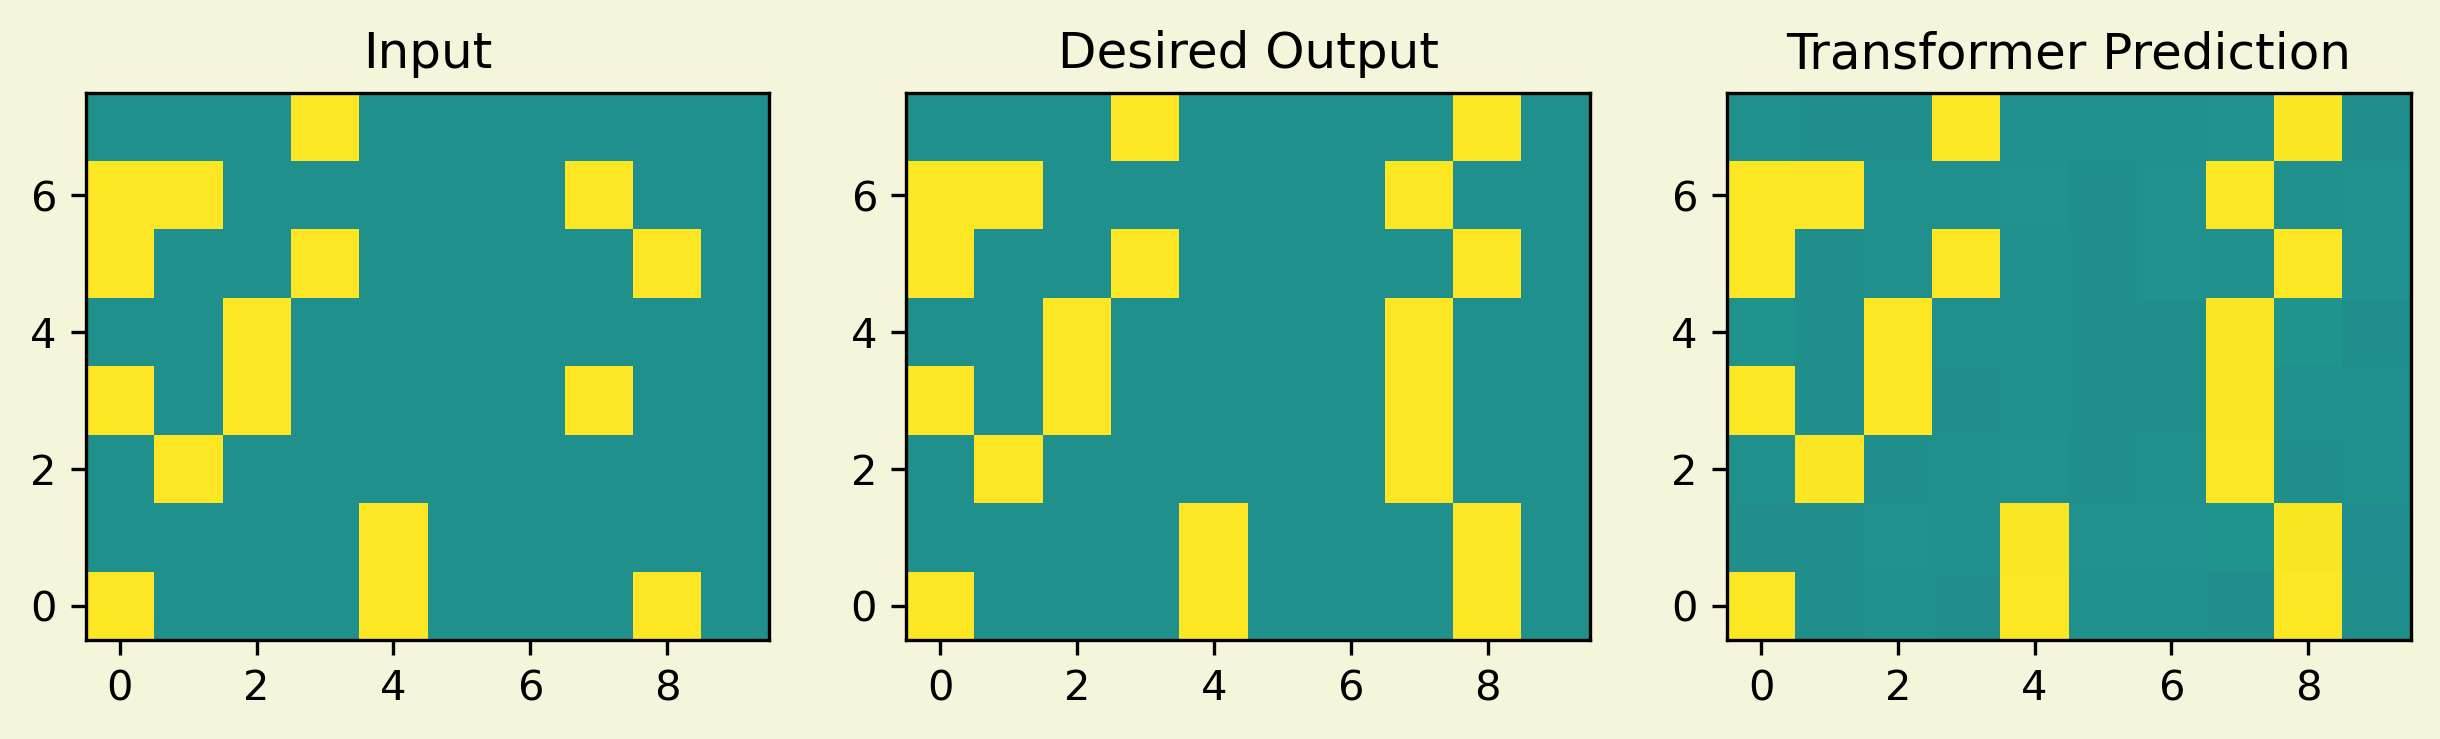

In [414]:
# obtain a test batch, but also store the random
# permutation of the objects (useful for obtaining the
# expected attention matrix later)
batch_permutations=[]
test_batch_in,test_batch_out=generate_batch_lookup_example(1,num_objects,vector_length,
                                                          provide_permutation=batch_permutations)
batch_permutations=batch_permutations[0] # was a batch of size 1, drop batch index

# apply transformer, but also receive weights for each layer,
# and also store the data vectors for all objects, for each layer
test_weights=[]
test_data_layers=[]
result=transformer(test_batch_in,                        
                         store_attention_weights=test_weights,
                        store_data_layers=test_data_layers)

# plot results (input/output/prediction)
fig, ax = plt.subplots(1,3, figsize=(10,3),dpi=300)
for idx,values in enumerate([test_batch_in[0], test_batch_out[0], result[0].numpy()]):
    ax[idx].imshow(values, vmin = -1., vmax = 1.,origin='lower')
ax[0].set_title("Input")
ax[1].set_title("Desired Output")
ax[2].set_title("Transformer Prediction")
plt.show()

Visualize data processing in all the layers


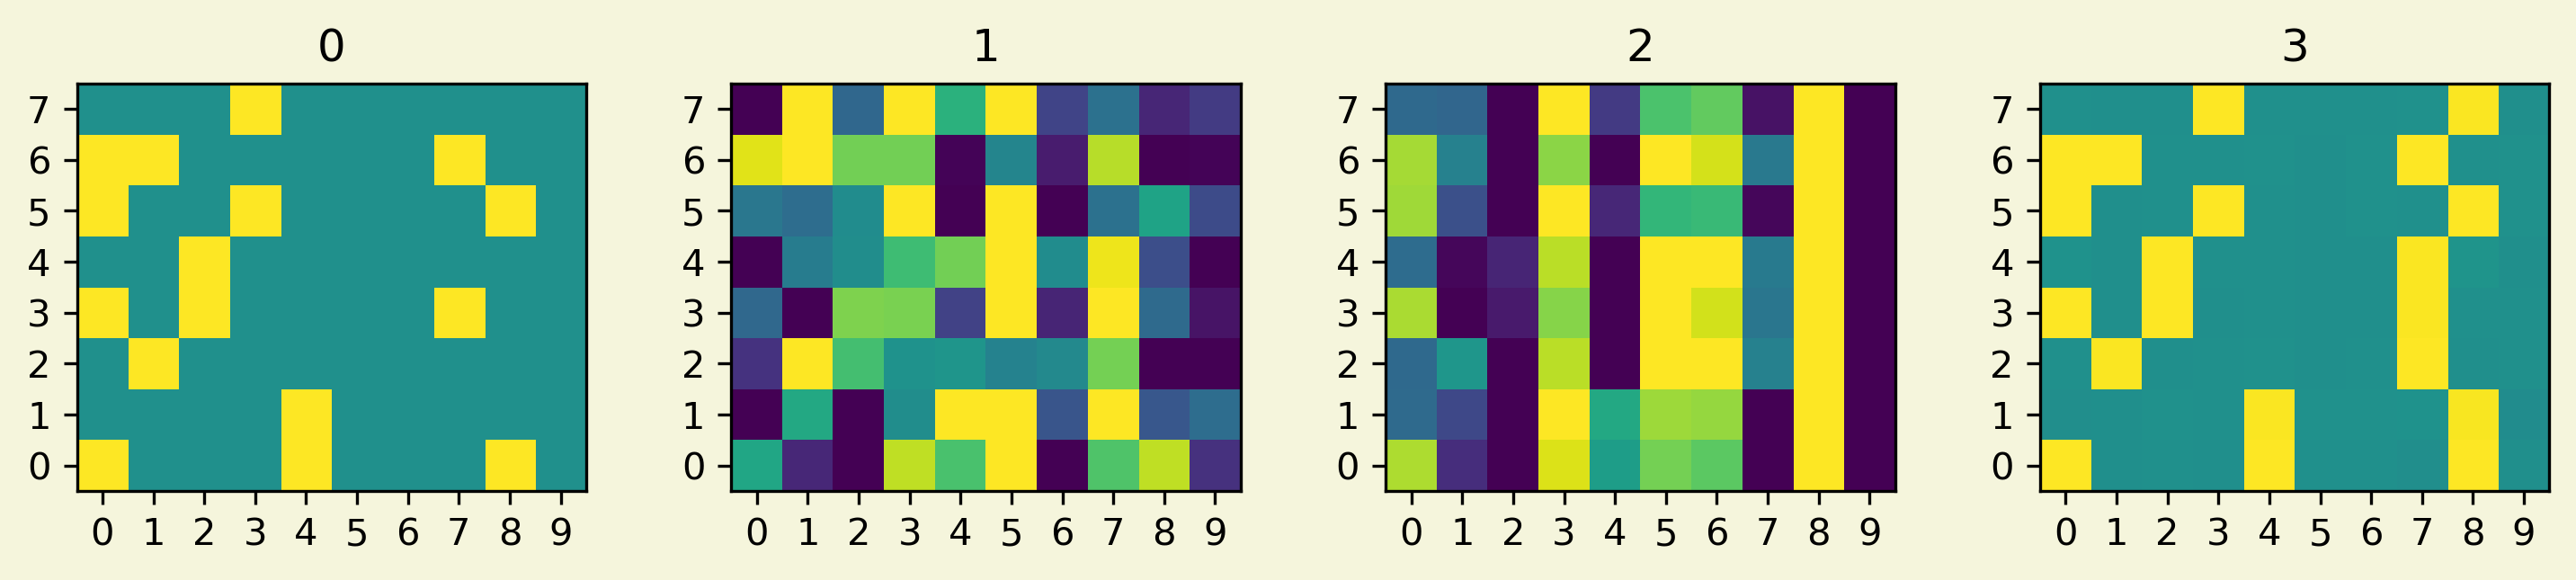

Explanation: Neuron activations during transformer processing pipeline, for all layers. Vertical axis: object index. Horizontal: vector component.

Visualize queries, keys, and values for all layers


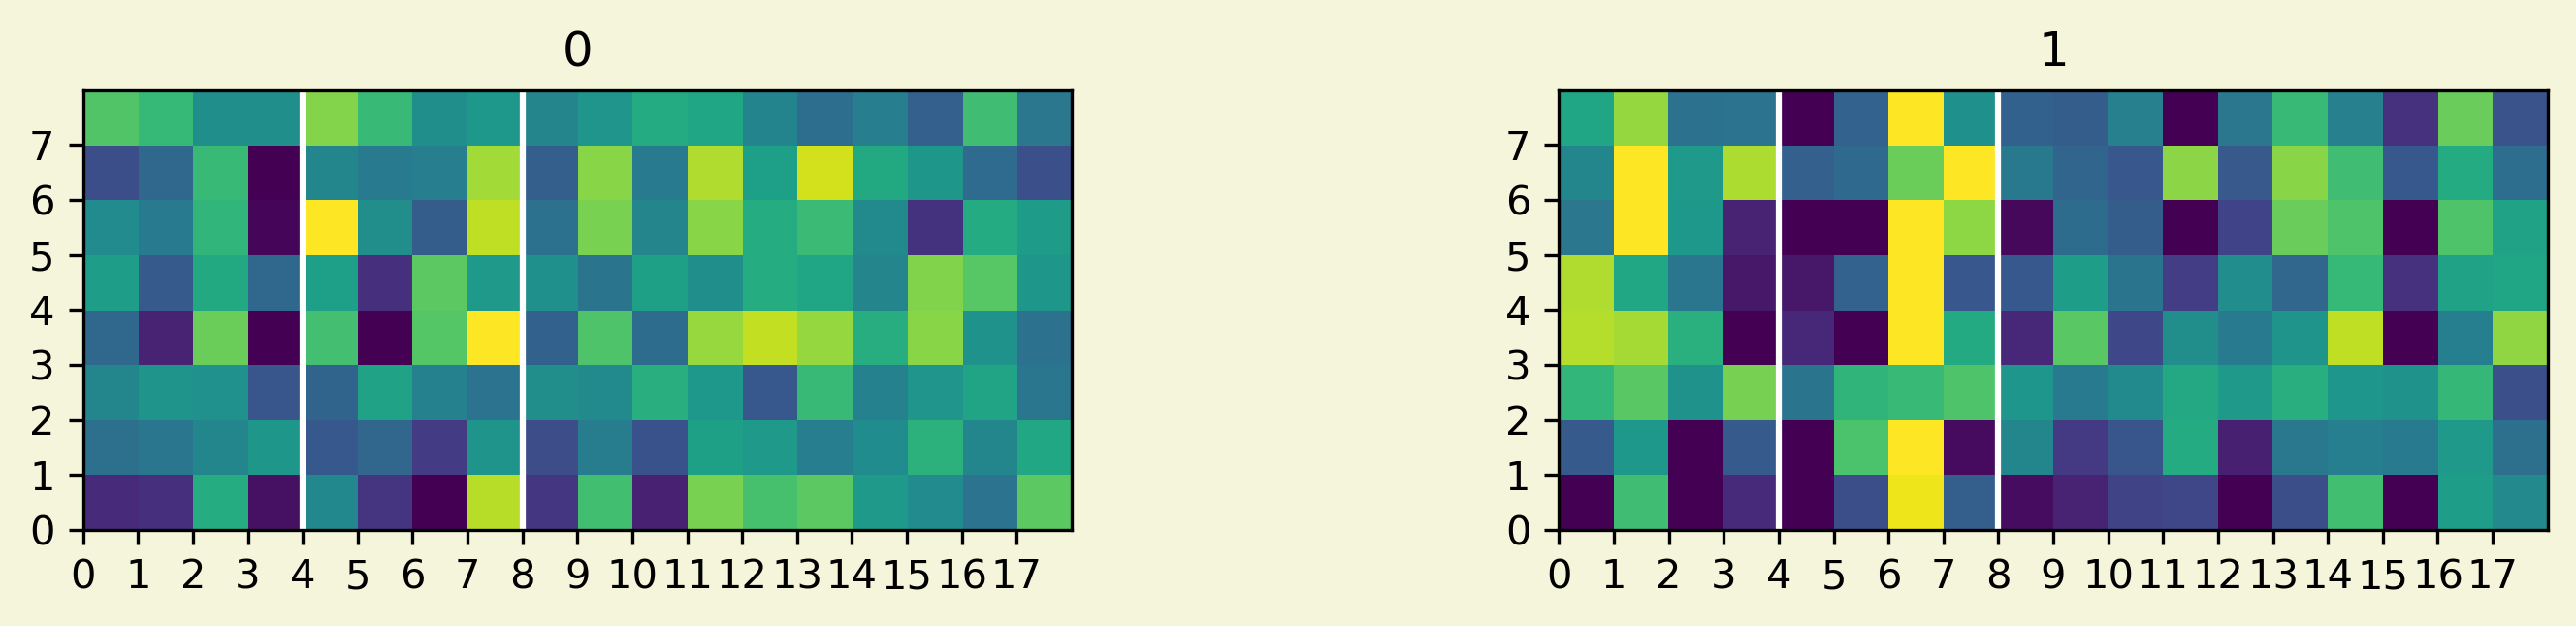

Explanation: For each layer, we show for each object (object index is vertical) the query, key and value vectors, from left to right in reach row.

Visualizing attentions


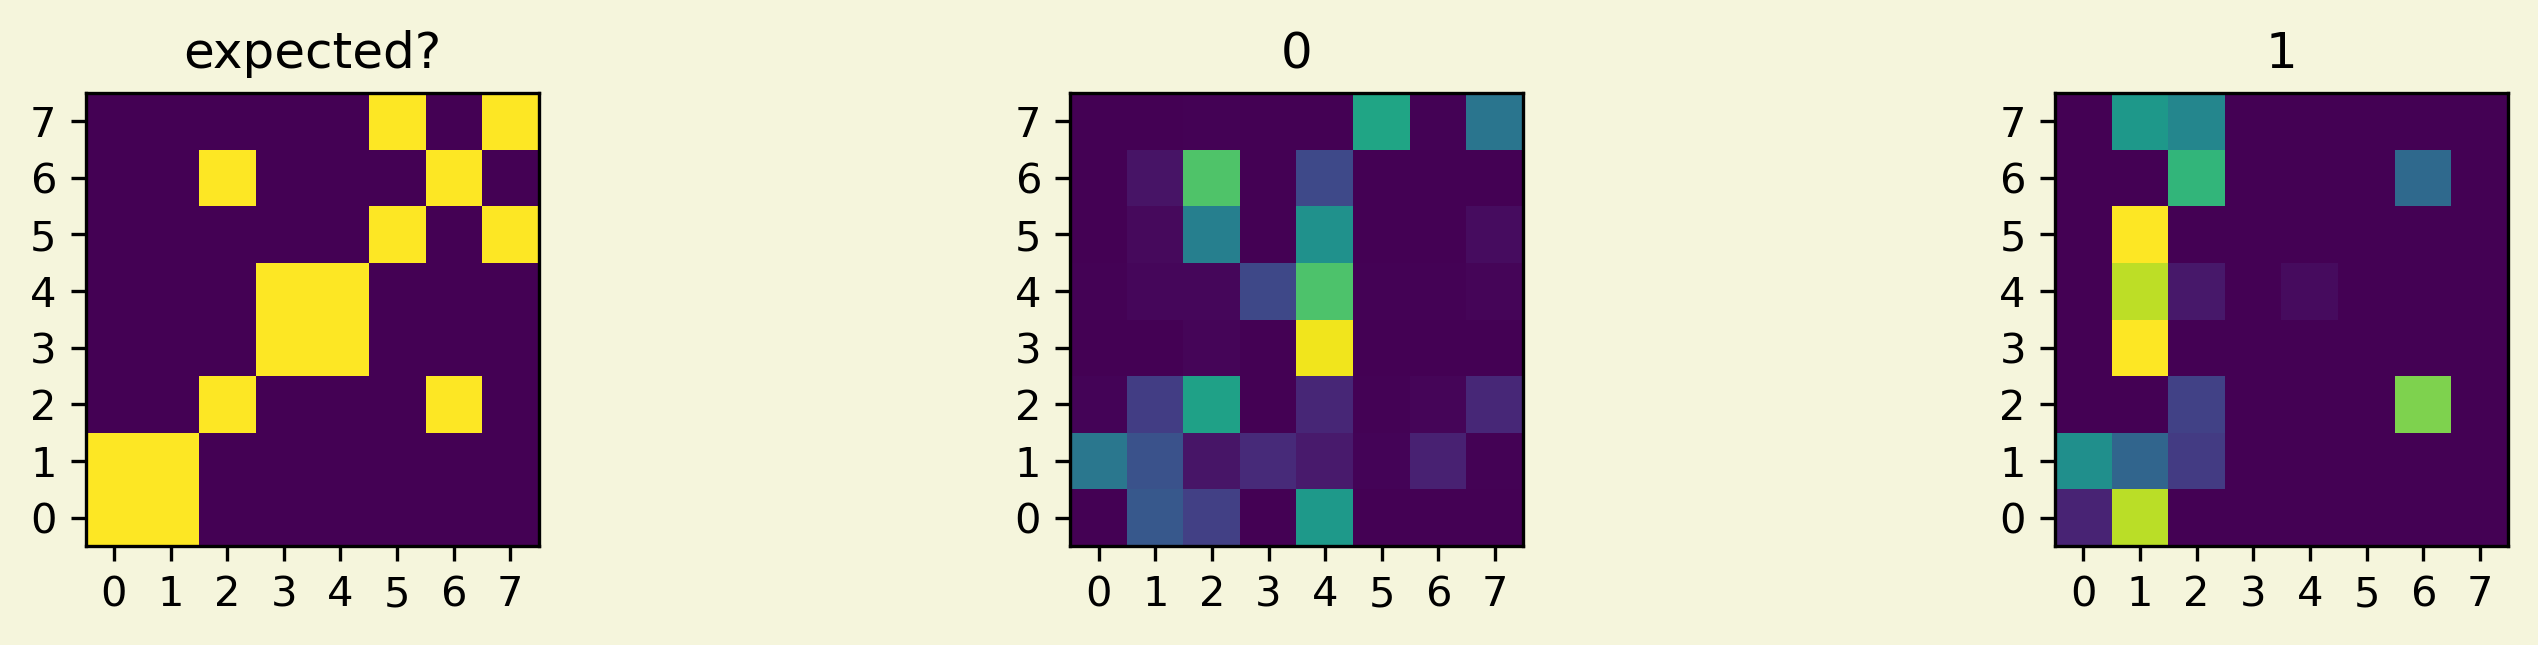

Explanation: Attention weights from object index (vertical axis) to some object index (horizontal axis). Sum of weights along each row is one. First panel shows naive expectation, from construction and random shuffling.



In [415]:
# obtain expected attention matrix
# objects with placeholders should attend to corresponding
# objects with the actual data; we need the permutation (that was imposed
# during the batch generation) to do this properly
half_num=num_objects//2
expected_attention=((batch_permutations[None,:]%half_num)==
                    (batch_permutations[:,None]%half_num))

# visualize data processing in the transformer

def all_ticks(ax,x_range=num_objects):
    ax.set_xticks(np.arange(x_range))
    ax.set_yticks(np.arange(num_objects))

print("Visualize data processing in all the layers")

fig,ax=plt.subplots(ncols=num_layers+2,dpi=300,figsize=(12,2))
for layer_idx in range(num_layers+2):
    ax[layer_idx].imshow(test_data_layers[layer_idx][0],origin='lower',vmin=-1,vmax=1)
    all_ticks(ax[layer_idx],x_range=dim_data)
    ax[layer_idx].set_title(str(layer_idx))
plt.show()
print("Explanation: Neuron activations during transformer processing pipeline, for all layers. Vertical axis: object index. Horizontal: vector component.")

print()

print("Visualize queries, keys, and values for all layers")

fig,ax=plt.subplots(ncols=num_layers,dpi=300,figsize=(12,2))
if num_layers==1:
    ax=[ax] # so we can access it as list...
for layer_idx in range(num_layers):
    data = test_data_layers[layer_idx][0]
    block = transformer.layers[layer_idx]
    Q = data @ block.WQ
    K = data @ block.WK
    V = data @ block.WV
    ax[layer_idx].imshow(Q,origin='lower',vmin=-4,vmax=4,
                         extent=(0,dim_key,0,num_objects))
    ax[layer_idx].imshow(K,origin='lower',vmin=-4,vmax=4,
                         extent=(dim_key,2*dim_key,0,num_objects))
    ax[layer_idx].imshow(V,origin='lower',vmin=-4,vmax=4,
                         extent=(2*dim_key,2*dim_key+dim_data,0,num_objects))
    ax[layer_idx].vlines([dim_key,2*dim_key],0,num_objects,color='white')

    all_ticks(ax[layer_idx],x_range=2*dim_key+dim_data)

    ax[layer_idx].set_title(str(layer_idx))
plt.show()
print("Explanation: For each layer, we show for each object (object index is vertical) the query, key and value vectors, from left to right in reach row.")

print()

print("Visualizing attentions")
fig,ax=plt.subplots(ncols=num_layers+1,dpi=300,figsize=(12,2))
ax[0].imshow(expected_attention,origin='lower')
all_ticks(ax[0])
ax[0].set_title("expected?")
for layer_idx in range(num_layers):
    ax[layer_idx+1].imshow(test_weights[layer_idx][0],origin='lower',vmin=0,vmax=1)
    all_ticks(ax[layer_idx+1])
    ax[layer_idx+1].set_title(str(layer_idx))
plt.show()
print("Explanation: Attention weights from object index (vertical axis) to some object index (horizontal axis). Sum of weights along each row is one. First panel shows naive expectation, from construction and random shuffling.")
print()



In [416]:
# text output of test:

print("Desired Output:")
print(np.round(test_batch_out[0],1))
print("Transformer Prediction:")
print(np.round(result[0].numpy(),1))


Desired Output:
[[1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]]
Transformer Prediction:
[[ 1. -0.  0. -0.  1.  0.  0. -0.  1. -0.]
 [-0. -0.  0.  0.  1.  0.  0.  0.  1. -0.]
 [ 0.  1. -0.  0.  0. -0.  0.  1. -0.  0.]
 [ 1. -0.  1. -0.  0. -0. -0.  1.  0.  0.]
 [ 0. -0.  1.  0.  0. -0. -0.  1.  0. -0.]
 [ 1. -0.  0.  1.  0. -0.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0. -0.  0.  1.  0.  0.]
 [ 0. -0. -0.  1.  0.  0.  0.  0.  1. -0.]]
